In [84]:
import numpy as np

# to map the circuit to the backend isa
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

#Visualization
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector

# SciPy minimizer routine
from scipy.optimize import minimize

# runtime imports
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import Aer

# 1. Setting up the Hamiltonian

In [76]:
hamiltonian = SparsePauliOp.from_list(
    [("XX", 1), ("YY", 1), ("ZI", 1)] # 1*XX + 1*YY + 1*ZI
)

# 2. Choosing the Ansatz
- I am using `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

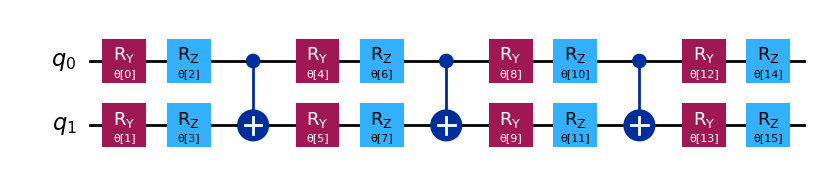

In [77]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
num_params = ansatz.num_parameters #Dimension of theta
ansatz.decompose().draw("mpl")

# 3. Execute using Qiskit Primitives

In [78]:
backend = Aer.get_backend('aer_simulator') #Aer simulator

In [79]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
} #This will store the cost through the minimization so as to enable loss landscape visualization

In [80]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    return energy

- We can now use a classical optimizer of our choice to minimize the cost function.
- I use the minimizer from Scipy.optimize.
- The exact method for the optimizer will be decided based on an error and feasibility analysis

# Mapping the ansatz circuit and the hamiltonian to the simulator ISA 

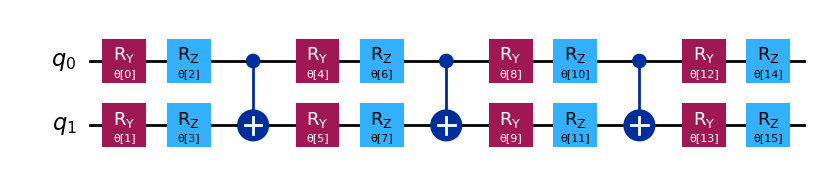

In [81]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
ansatz_isa.draw("mpl")

# Choosing the best method for cost function minimization

After trying the 14 available methods, the following were deemed useless:
- `Nelder-Mead` - Gradient-free approach - Taking a lot of time
- `CG`, `BFGS` - Desired error not necessarily achieved due to precision loss.
- `Newton-CG`, `dogleg`, `trust-ncg`, `trust-exact`, `trust-krylov` - More complex, Jacobian computation required
- `L-BFGS-B`, `TNC` - Couldn't converge - Oscillating series
- `SLSQP`, `trust-constr` - Incorrect results

Considering this, I compare the remaining two options: 'Powell' and 'COBYLA' - The comparison is done between the average MAE between the desired and the obtained eigenvalue over 5 iterations for the two solvers. 

- First we'll use the Qiskit NumPyMinimumEigensolver to get the ""correct"" eigenvalue

In [82]:
from qiskit_algorithms import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(hamiltonian)

- Now we proceed with the comparison

In [33]:
methods = ['COBYLA', 'Powell'] #available methods that converge close to the correct value

min_diff = np.inf
min_diff_method = ''
min_diff_res = []

for method in methods: #iterating for the two methods

    eigenvalue_difference = []
    for i in range(5): #Repeating 5 times to accomodate for randomization
        cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        }
        
        x0 = 2 * np.pi * np.random.random(num_params)

        with Session(backend=backend) as session:
            estimator = Estimator(mode=session)
            estimator.options.default_shots = 10000

            res = minimize(
                cost_func,
                x0,
                args=(ansatz_isa, hamiltonian_isa, estimator),
                method=method,
            )
        
        eigenvalue_difference.append(abs(res.fun - result.eigenvalue))
        print(f"{method}: {i} done")
        
    if(np.sum(eigenvalue_difference) < min_diff):
        min_diff = np.sum(eigenvalue_difference)
        min_diff_method = method
        min_diff_res = res
    

    print(f"\t\t{method}: {np.sum(eigenvalue_difference)}")


COBYLA: 0 done
COBYLA: 1 done
COBYLA: 2 done
COBYLA: 3 done
COBYLA: 4 done
		COBYLA: 0.13493988749892694
Powell: 0 done
Powell: 1 done
Powell: 2 done
Powell: 3 done
Powell: 4 done
		Powell: 0.03166797749978567


# Running the final simulation with the best solver 

In [75]:
x0 = 2 * np.pi * np.random.random(num_params)

In [85]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [49]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="Powell",
    )

In [56]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.225
       x: [ 6.935e+00  5.814e+00 ...  5.447e+00  6.094e+00]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 1408

In [51]:
ansatz_isa_params = ansatz_isa.assign_parameters(res.x)
ansatz_isa_params.save_statevector()
resulting_eigenstate_1 = backend.run(ansatz_isa_params).result().get_statevector()

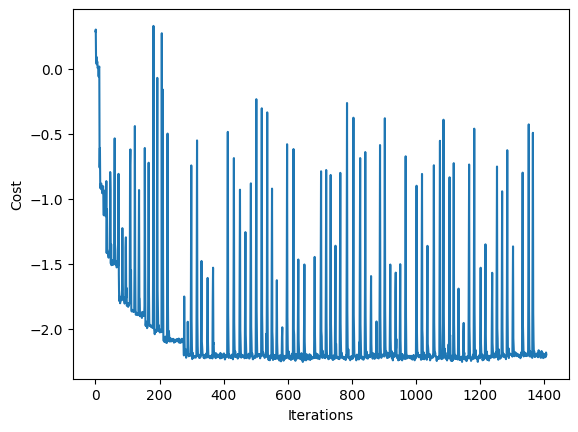

In [52]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()
plt.show()

- Even though the `Powell` solver succeedes in providing a very close solution to that obtained by the NumPyMinimumSolver, we observe that the loss landscape is pretty unstable, and for that reason I proceed with the `COBYLA` solver. 

In [68]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [69]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res_cobyla = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
    )

In [70]:
res_cobyla

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2254
       x: [ 5.332e+00  5.818e+00 ...  6.428e+00  6.104e+00]
    nfev: 160
   maxcv: 0.0

In [71]:
ansatz_isa_params_cobyla = ansatz_isa.assign_parameters(res_cobyla.x)
ansatz_isa_params_cobyla.save_statevector()
resulting_eigenstate_1_cobyla = backend.run(ansatz_isa_params_cobyla).result().get_statevector()

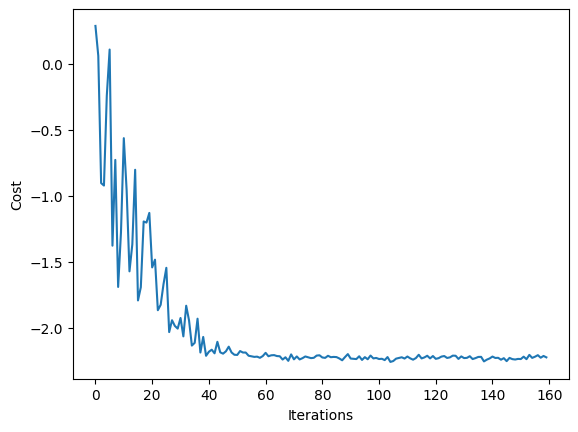

In [72]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()
plt.show()

# Qiskit NumPyMinimumEigensolver

In [73]:
from qiskit_algorithms import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(hamiltonian)

# Results

## 1. Scipy solver with a 16 parameter ansatz

### Powell

The minimum eignevalue obtained is -2.225, with the following eigenstate:


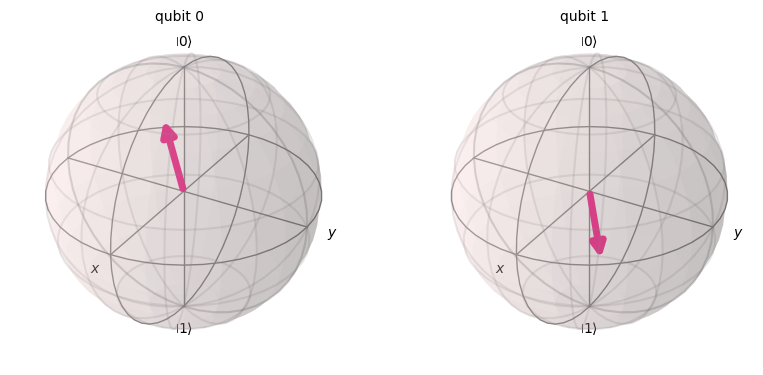

In [54]:
print(f"The minimum eignevalue obtained is {res.fun}, with the following eigenstate:")
plot_bloch_multivector(resulting_eigenstate_1)

### COBYLA

The minimum eignevalue obtained is -2.2254, with the following eigenstate:


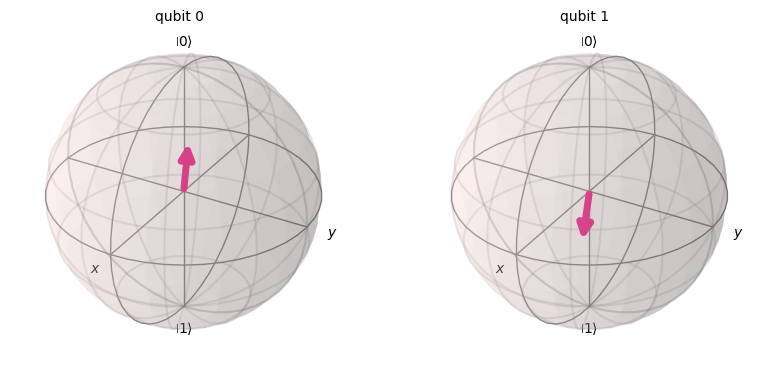

In [74]:
print(f"The minimum eignevalue obtained is {res_cobyla.fun}, with the following eigenstate:")
plot_bloch_multivector(resulting_eigenstate_1_cobyla)

## 2. NumPyMinimumEigensolver

The minimum eignevalue obtained by NumPyMinimumEigensolver is -2.23606797749979, with the following eigenstate:


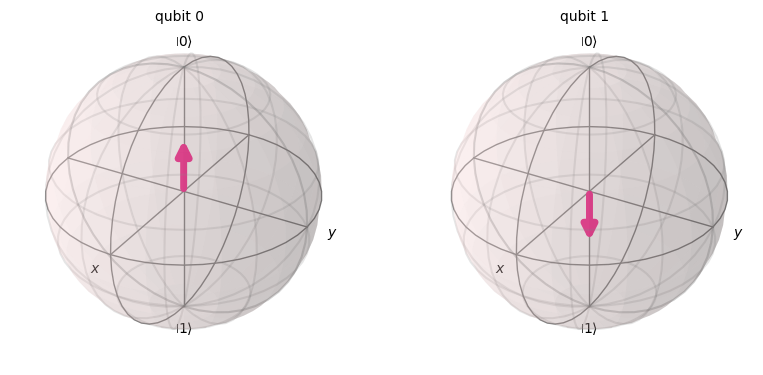

In [55]:
print(f"The minimum eignevalue obtained by NumPyMinimumEigensolver is {result.eigenvalue}, with the following eigenstate:")
plot_bloch_multivector(result.eigenstate)

# Final conclusions
- In Scipy.optimize, out of the 14 available solver methods, only 2 were suitable for this scenario.
- These were the `Powell` and `COBYLA` methods.
- From an error analysis POV, the results from `Powell` showed higher similarity to those from the NumPyMinimumEigensolver.
- But, `COBYLA` outperformed `Powell` in terms of the monotonicity and stability of the loss landscape.
- The Final minimum Eigenvalues for the two methods do get very close to that obtained from the NumPyMinimumEigensolver.
- After running the experiment multiple times, the final Eigenstate was found to be unstable, sensitive to the initial guess x0.